In [10]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Linear Inverted Pendulum

An inverted pendulum on a motorized cart is a classic control systems problem. The goal is to move the cart to keep the pendulum balanced upright. This is challenging because the system is naturally unstable and has nonlinear dynamics, similar to the problem of keeping a rocket stable during takeoff.

## System Description

Consider a two-dimensional problem where the pendulum is constrained to move in the vertical plane shown in the figure below. For this system, the control input is the force $F$ that moves the cart horizontally and the outputs are the angular position of the pendulum $\theta$ and the horizontal position of the cart $x$.

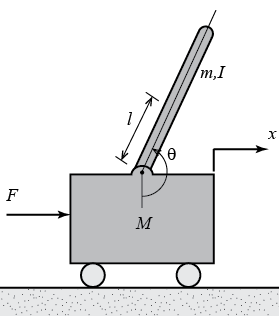

- (M)       mass of the cart                         0.5 kg
- (m)       mass of the pendulum                     0.2 kg
- (b)       coefficient of friction for cart         0.1 N/m/sec
- (l)       length to pendulum center of mass        0.3 m
- (I)       mass moment of inertia of the pendulum   0.006 kg.m^2
- (F)       force applied to the cart
- (x)       cart position coordinate
- (theta)   pendulum angle from vertical (down)

 In classiscal control (SISO) design requirements for this system are:
- Settling time for $\theta$ of less than 5 seconds
- Pendulum angle $\theta$ never more than 0.05 radians from the vertical


In state space design,the design requirements for the inverted pendulum are:
- Settling time for $x$ and $\theta$ of less than 5 seconds
- Rise time for $x$ of less than 0.5 seconds
- Pendulum angle $\theta$ never more than 20 degrees (0.35 radians) from the vertical
- Steady-state error of less than 2% for $x$ and $\theta


In [3]:
# Define system parameters
M = 0.5
m = 0.2
b = 0.1
I = 0.006
g = 9.8
l = 0.3

## System Modeling

### Force analysis

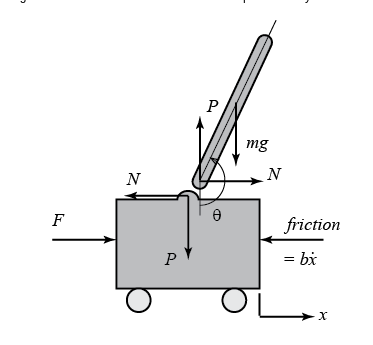

Considering the free-body diagrams of the two elements of the inverted pendulum system.

The forces of the cart in the horizontal direction,
$$M\ddot{x}+b\dot{x}+N = F\tag{1}$$

The forces of the pendulum in the horizontal direction,
position of pendulum, 
$$x_p = x + l \sin(\theta) $$
$$\dot{x_p} = \dot{x} + l \cos(\theta) \dot{\theta} $$
$$\ddot{x_p} = \ddot{x} - l \sin(\theta) \dot{\theta}^2 + l \cos(\theta) \ddot{\theta} $$
Therefore,
$$m\ddot{x_p} = N $$
$$m(\ddot{x} - l \sin(\theta) \dot{\theta}^2 + l \cos(\theta) \ddot{\theta}) = N \tag{2} $$

By substitution of (2) in (1),
$$M\ddot{x}+b\dot{x}+ m(\ddot{x} - l \sin(\theta) \dot{\theta}^2 + l \cos(\theta) \ddot{\theta}) = F \tag{3}$$


Cosidering the pedulum,
Acceleration from rotation
$$ l\ddot{\theta} $$
Acceleration from cart
$$\ddot{x}\cos(\theta) $$

Considering the forces perpendicular to the pendulum
$$ P \sin(\theta)+N \cos(\theta)-mg \sin(\theta) = m (l\ddot{\theta}+\ddot{x}\cos(\theta)) \tag{4}$$

Sum of the moments about the centroid of the pendulum,
$$ -Pl \sin(\theta) - Nl \cos(\theta) = I \ddot{\theta} \tag{5}$$

From (4) and (5)
$$(I + m l^2)\ddot(\theta) + mgl \sin(\theta) = -ml\ddot{x}\cos(\theta) \tag{6}$$

Nonlinear governing equations,
$$M\ddot{x}+b\dot{x}+ m(\ddot{x} - l \sin(\theta) \dot{\theta}^2 + l \cos(\theta) \ddot{\theta}) = F$$

$$(I + m l^2)\ddot{\theta} + mgl \sin(\theta) = -ml\ddot{x}\cos(\theta)$$

### Linearization

Since the analysis and control design techniques we will be employing in this example apply only to linear systems, this set of equations needs to be linearized. 

To do that we need to select a fixed position. There are two fixed possitions to this system, pendulum down position ($\theta$ = 0) and up position ($\theta$ = $\pi$). Let's assume that the system stays within a small neighborhood of up position.

Let $\phi$ represent the deviation of the pedulum's position from equilibrium,
$$ \theta = \pi + \phi $$

Assuming small deviations, 
$$ \cos(\theta) = \cos(\pi + \phi) \approx -1 $$
$$ \sin(\theta) = \sin(\pi + \phi) \approx -\phi $$
$$ \dot{\theta}^2 = \dot{\phi}^2 \approx 0 $$

After substiting the above approximations into our nonlinear governing equations,
$$(M+m)\ddot{x}+b\dot{x} - m l\ddot{\theta} = u$$
$$(I + m l^2)\ddot{\theta} - mgl\phi = ml\ddot{x}$$

### Transer Function 

Take the Laplace transform of the system equations assuming zero initial conditions.
$$(M+m)X(s)s^2+bX(s)s-ml\Phi(s)s^2=U(s)$$
$$(I+ml^2)\Phi(s)s^2-mgl\Phi(s)=mlX(s)s^2$$

Solve the second equation for $X(s)$. 
$$ X(s)=\left[{\frac{I+ml^2}{ml}-\frac{g}{s^2}}\right]\Phi(s) $$

Then substitute the above into the first equation.
$$(M+m)\left[\frac{I+ml^2}{ml}-\frac{g}{s^2}\right]\Phi(s)s^2+b\left[\frac{I+ml^2}{ml}-\frac{g}{s^2}\right]\Phi(s)s-ml\Phi(s)s^2=U(s)$$

Therefore the TF of the pendulum, 
$$P_{pend}(s) = \frac{\Phi(s)}{U(s)}=\frac{\frac{ml}{q}s}{s^3+\frac{b(I+ml^2)}{q}s^2-\frac{(M+m)mgl}{q}s-\frac{bmgl}{q}} \qquad [ \frac{rad}{N}]$$

Second, the transfer function with the cart position $X(s)$ as the output can be derived in a similar manner to arrive at the following. 
$$P_{cart}(s) = \frac{X(s)}{U(s)} = \frac{ \frac{ (I+ml^2)s^2 - gml } {q} }{s^4+\frac{b(I+ml^2)}{q}s^3-\frac{(M+m)mgl}{q}s^2-\frac{bmgl}{q}s} \qquad [ \frac{m}{N}] $$
where,
$$q=[(M+m)(I+ml^2)-(ml)^2]$$

### State-Space

The linearized equations of motion from above can also be represented in state-space form if they are rearranged into a series of first order differential equations.

First, we select the variables that fully describe the system's state. For this system, we need the cart's position and velocity, and the pendulum's angle and angular velocity. We define the state vector $z$ as:

$$
x = \begin{bmatrix} x \\ \dot{x} \\ \phi \\ \dot{\phi} \end{bmatrix}
$$

Our goal is to find the matrices $A$ and $B$ for the state equation:
$$
\dot{x} = Ax + Bu
$$

Next, we must algebraically manipulate the two governing equations to solve for the second derivatives, $\ddot{x}$ and $\ddot{\phi}$, in terms of the state variables and the input $u$.

From equation (2), we can isolate $\ddot{x}$:
$$
\ddot{x} = \frac{(I + ml^2)}{ml}\ddot{\phi} - g\phi
$$

Now, substitute this expression for $\ddot{x}$ into equation (1):
$$
(M+m)\left[ \frac{(I + ml^2)}{ml}\ddot{\phi} - g\phi \right] + b\dot{x} - ml\ddot{\phi} = u
$$

To solve for $\ddot{\phi}$, we expand and group the $\ddot{\phi}$ terms:
$$
\left[ \frac{(M+m)(I + ml^2)}{ml} - ml \right]\ddot{\phi} = u - b\dot{x} + (M+m)g\phi
$$

Let's define a common denominator term, $\Delta$, to simplify the expression:
$$
\Delta = I(M+m)+Mml^2
$$

With this, we can solve for $\ddot{\phi}$ and $\ddot{x}$:
$$
\ddot{\phi} = \frac{ml}{\Delta} u - \frac{ml b}{\Delta} \dot{x} + \frac{(M+m)mgl}{\Delta} \phi
$$
$$
\ddot{x} = \frac{I+ml^2}{\Delta} u - \frac{b(I+ml^2)}{\Delta} \dot{x} + \frac{(ml)^2g}{\Delta} \phi
$$

Using these relationships, we can assemble the state equation $\dot{x} = Ax + Bu$:

$$
\begin{bmatrix} \dot{x} \\ \ddot{x} \\ \dot{\phi} \\ \ddot{\phi} \end{bmatrix} =
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & -\frac{b(I+ml^2)}{\Delta} & \frac{(ml)^2g}{\Delta} & 0 \\
0 & 0 & 0 & 1 \\
0 & -\frac{ml b}{\Delta} & \frac{(M+m)mgl}{\Delta} & 0
\end{bmatrix}
\begin{bmatrix} x \\ \dot{x} \\ \phi \\ \dot{\phi} \end{bmatrix}
+
\begin{bmatrix}
0 \\
\frac{I+ml^2}{\Delta} \\
0 \\
\frac{ml}{\Delta}
\end{bmatrix}
u
$$

This gives us our $A$ and $B$ matrices. If we want to define an output equation $y = Cz + Du$, we can select the states we wish to observe. For example, to observe the cart's position ($x$) and the pendulum's angle ($\phi$), the $C$ and $D$ matrices would be:

$$
y =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}
z
+
\begin{bmatrix}
0 \\
0
\end{bmatrix}
u
$$

### Python Representation

#### Transfer Function

In [6]:
# Calculate the common denominator term
q = (M + m) * (I + m * l**2) - (m * l)**2

# reate the transfer function variable 's'
s = ct.tf('s')

# Define the two transfer functions
den_base = s**3 + (b * (I + m * l**2) / q) * s**2 \
         - ((M + m) * m * g * l / q) * s \
         - (b * m * g * l / q)

# Transfer function for the cart's position (u -> x)
num_cart = ((I + m * l**2) / q) * s**2 - (m * g * l / q)
den_cart = s * den_base
P_cart = num_cart / den_cart

# Transfer function for the pendulum's angle (u -> phi)
num_pend = (m * l / q) * s
den_pend = den_base
P_pend = num_pend / den_pend

In [7]:
# Create the State-Input, Multi-Output (SIMO) system
sys_tf = ct.tf([[P_cart], [P_pend]]) 

# Set input and output names
sys_tf.input_name = 'u'
sys_tf.output_name = ['x', 'phi']

# Display the resulting system
print("--- Cart Transfer Function (u to x) ---")
print(P_cart)
print("\n--- Pendulum Transfer Function (u to phi) ---")
print(P_pend)
print("\n--- Combined System ---")
print(sys_tf)

--- Cart Transfer Function (u to x) ---
<TransferFunction>: sys[53]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

            1.818 s^2 - 44.55
  --------------------------------------
  s^4 + 0.1818 s^3 - 31.18 s^2 - 4.455 s

--- Pendulum Transfer Function (u to phi) ---
<TransferFunction>: sys[56]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

               4.545 s
  ----------------------------------
  s^3 + 0.1818 s^2 - 31.18 s - 4.455

--- Combined System ---
<TransferFunction>: sys[57]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']

Input 1 to output 1:

            1.818 s^2 - 44.55
  --------------------------------------
  s^4 + 0.1818 s^3 - 31.18 s^2 - 4.455 s

Input 1 to output 2:

               4.545 s
  ----------------------------------
  s^3 + 0.1818 s^2 - 31.18 s - 4.455


#### State Space

In [8]:
# Denominator for the A and B matrices
p = I * (M + m) + M * m * l**2

# --- State-Space Matrices ---
A = np.array([
    [0, 1, 0, 0],
    [0, -(I + m * l**2) * b / p, (m**2 * g * l**2) / p, 0],
    [0, 0, 0, 1],
    [0, -(m * l * b) / p, m * g * l * (M + m) / p, 0]
])

B = np.array([
    [0],
    [(I + m * l**2) / p],
    [0],
    [m * l / p]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

D = np.array([
    [0],
    [0]
])

# --- Create the State-Space Model ---
sys_ss = ct.ss(A, B, C, D)

# Assign the names during creation for a more direct translation
states = ['x', 'x_dot', 'phi', 'phi_dot']
inputs = ['u']
outputs = ['x', 'phi']
sys_ss = ct.ss(A, B, C, D, states=states, inputs=inputs, outputs=outputs)

# --- Print the system to verify ---
print(sys_ss)

<StateSpace>: sys[59]
Inputs (1): ['u']
Outputs (2): ['x', 'phi']
States (4): ['x', 'x_dot', 'phi', 'phi_dot']

A = [[ 0.          1.          0.          0.        ]
     [ 0.         -0.18181818  2.67272727  0.        ]
     [ 0.          0.          0.          1.        ]
     [ 0.         -0.45454545 31.18181818  0.        ]]

B = [[0.        ]
     [1.81818182]
     [0.        ]
     [4.54545455]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0.]
     [0.]]


Generate the Transfer Function from State-Space 

In [9]:
sys_tf = ct.tf(sys_ss)

print("State-Space Model:")
print(sys_ss)
print("\n" + "="*40 + "\n")
print("Equivalent Transfer Function Model:")
print(sys_tf)

State-Space Model:
<StateSpace>: sys[59]
Inputs (1): ['u']
Outputs (2): ['x', 'phi']
States (4): ['x', 'x_dot', 'phi', 'phi_dot']

A = [[ 0.          1.          0.          0.        ]
     [ 0.         -0.18181818  2.67272727  0.        ]
     [ 0.          0.          0.          1.        ]
     [ 0.         -0.45454545 31.18181818  0.        ]]

B = [[0.        ]
     [1.81818182]
     [0.        ]
     [4.54545455]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0.]
     [0.]]


Equivalent Transfer Function Model:
<TransferFunction>: sys[60]
Inputs (1): ['u']
Outputs (2): ['x', 'phi']

Input 1 to output 1:

  9.992e-16 s^3 + 1.818 s^2 + 4.441e-15 s - 44.55
  -----------------------------------------------
      s^4 + 0.1818 s^3 - 31.18 s^2 - 4.455 s

Input 1 to output 2:

  -8.882e-16 s^3 + 4.545 s^2 - 1.421e-14 s
  ----------------------------------------
   s^4 + 0.1818 s^3 - 31.18 s^2 - 4.455 s


## System Analysis

#### Open-loop Analysis

Cart Position:
  Poles: [ 5.56510758+0.j -5.60409413+0.j -0.14283164+0.j  0.        +0.j]
  Zeros: [-4.94974747+0.j  4.94974747+0.j]
Pendulum Angle:
  Poles: [ 5.56510758+0.j -5.60409413+0.j -0.14283164+0.j]
  Zeros: [0.+0.j]


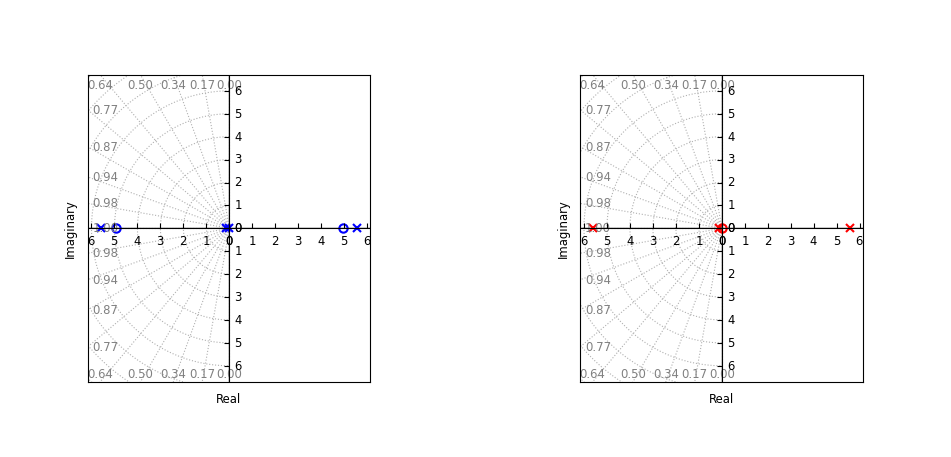

In [38]:
# If you need the actual pole/zero values for analysis
poles_cart, zeros_cart = ct.poles(P_cart), ct.zeros(P_cart)
poles_pend, zeros_pend = ct.poles(P_pend), ct.zeros(P_pend)

print("Cart Position:")
print(f"  Poles: {poles_cart}")
print(f"  Zeros: {zeros_cart}")

print("Pendulum Angle:")
print(f"  Poles: {poles_pend}")
print(f"  Zeros: {zeros_pend}")

fig = plt.figure(figsize=(10, 5))  # Set size here

ax_array = ct.pole_zero_subplots(1, 2, grid=True, fig=fig)

# Plot cart position on first subplot
ct.pole_zero_plot(P_cart, ax=ax_array[0, 0], 
                  title='Cart Position ($u \\to x$)', color='blue')

# Plot pendulum angle on second subplot  
ct.pole_zero_plot(P_pend, ax=ax_array[0, 1],
                  title='Pendulum Angle ($u \\to \\phi$)', color='red')

plt.tight_layout()
plt.show()

#### Open Loop Response 

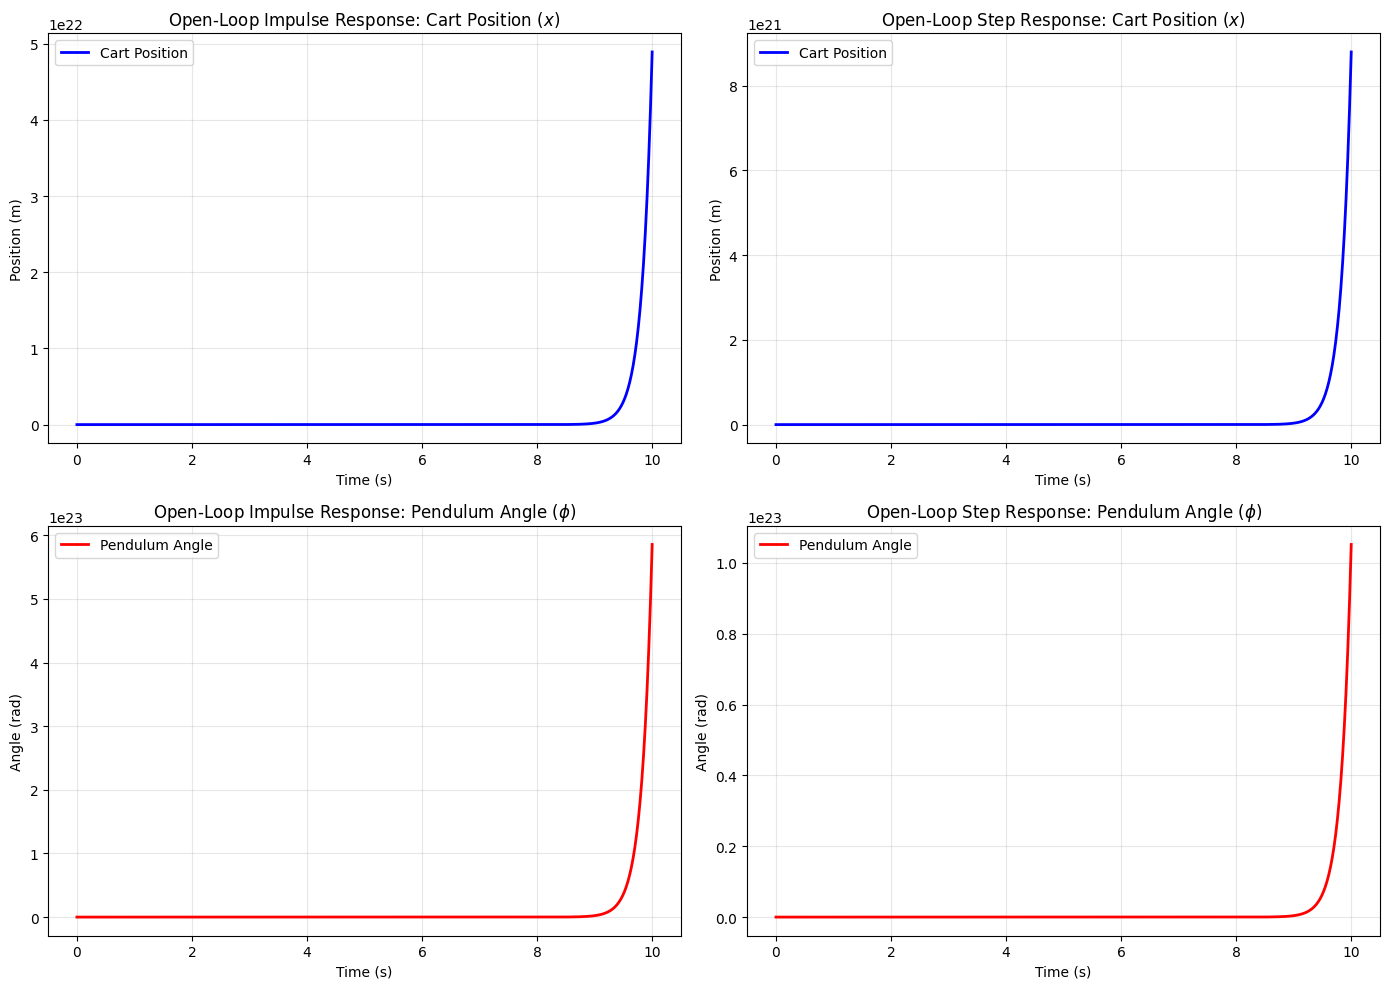

In [37]:

# Create a 2x2 subplot for comprehensive analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time vector for simulation
t = np.linspace(0, 10, 1000)  # Adjust time range as needed

# 1. Impulse Response - Cart Position
t_imp_cart, y_imp_cart = ct.impulse_response(P_cart, T=t)
axes[0, 0].plot(t_imp_cart, y_imp_cart, 'b-', linewidth=2, label='Cart Position')
axes[0, 0].set_title('Open-Loop Impulse Response: Cart Position ($x$)')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Position (m)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Impulse Response - Pendulum Angle
t_imp_pend, y_imp_pend = ct.impulse_response(P_pend, T=t)
axes[1, 0].plot(t_imp_pend, y_imp_pend, 'r-', linewidth=2, label='Pendulum Angle')
axes[1, 0].set_title('Open-Loop Impulse Response: Pendulum Angle ($\\phi$)')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Angle (rad)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 3. Step Response - Cart Position
t_step_cart, y_step_cart = ct.step_response(P_cart, T=t)
axes[0, 1].plot(t_step_cart, y_step_cart, 'b-', linewidth=2, label='Cart Position')
axes[0, 1].set_title('Open-Loop Step Response: Cart Position ($x$)')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Position (m)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 4. Step Response - Pendulum Angle
t_step_pend, y_step_pend = ct.step_response(P_pend, T=t)
axes[1, 1].plot(t_step_pend, y_step_pend, 'r-', linewidth=2, label='Pendulum Angle')
axes[1, 1].set_title('Open-Loop Step Response: Pendulum Angle ($\\phi$)')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Angle (rad)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Control

### PID Control

#### PID Control Tuning for Pendulum

In [83]:
def PID_Control_Pendulum(TF,Kp = 100.0, Ki = 1.0, Kd = 1.0):    
    # Define the PID Controller transfer function C(s) = Kp + Ki/s + Kd*s
    # To define it using ct.tf, we need a common denominator 's':
    # C(s) = (Kd*s^2 + Kp*s + Ki) / s
    num_C = [Kd, Kp, Ki]
    den_C = [1, 0] # Represents 's'
    C = ct.tf(num_C, den_C)

    
    # Calculate the closed-loop system T(s) = P_pend / (1 + P_pend * C)
    # Assuming a negative feedback loop: T = feedback(P_pend, C)
    T = ct.feedback(TF, C)
    t = np.arange(0, 10.01, 0.01)
    t_out, y_out = ct.impulse_response(T, T=t)
    
    # Plot the result
    plt.figure(figsize=(8, 5))
    plt.plot(t_out, y_out)
    plt.title('Response of Pendulum Position to an Impulse Disturbance')
    plt.xlabel('Time (s)')
    plt.ylabel('Pendulum Angle ($\\phi$)')
    plt.grid(True)
    plt.show()

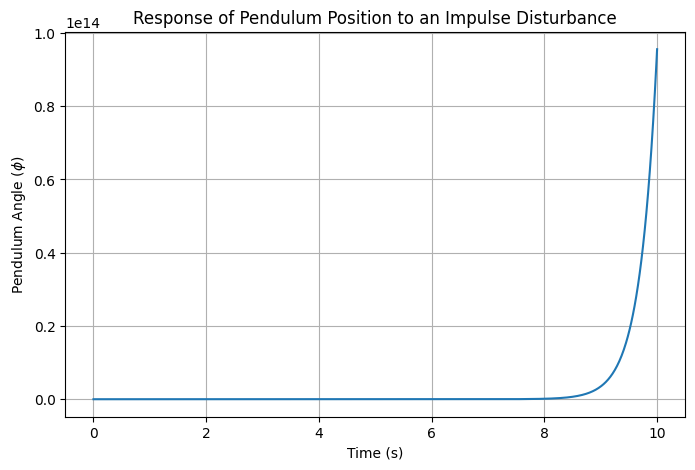

In [84]:
PID_Control_Pendulum(P_pend,1,1,1)

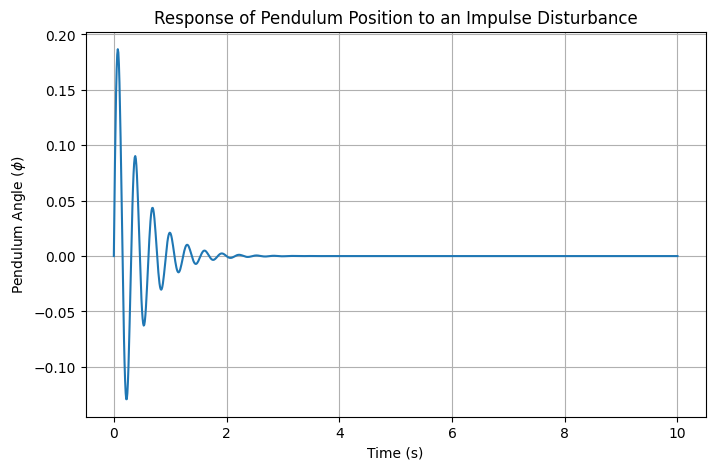

In [85]:
PID_Control_Pendulum(P_pend,100,1,1)

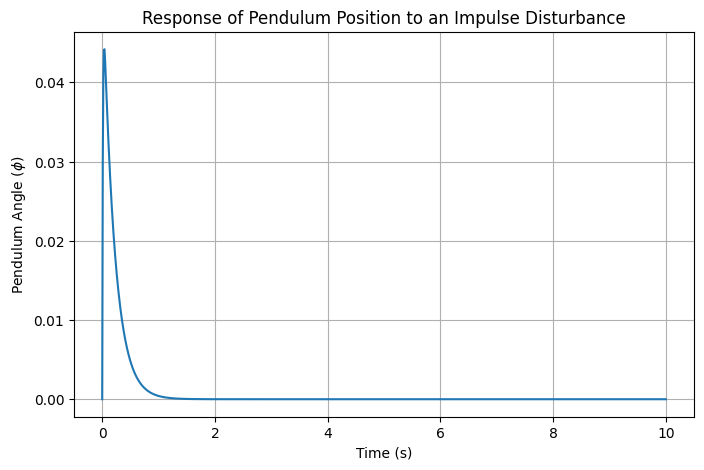

In [86]:
PID_Control_Pendulum(P_pend,100,1,20)

#### PID Control for System

In [120]:
def PID_Control(TF_pend,TF_cart,Kp = 1.0, Ki = 1.0, Kd = 1.0,K=1):   
    # Define the PID Controller transfer function C(s) = Kp + Ki/s + Kd*s
    # To define it using ct.tf, we need a common denominator 's':
    # C(s) = (Kd*s^2 + Kp*s + Ki) / s
    num_C = [Kd, Kp, Ki]
    den_C = [1, 0] # Represents 's'
    C = ct.tf(num_C, den_C)
    # T1 (Impulse Input u -> Pendulum Angle phi)
    T1 = ct.feedback(TF_pend, C*K) 
    
    # T2 (Impulse Input u -> Cart Position x)
    T2 = ct.feedback(1, TF_pend * C) * TF_cart
    
    t = np.arange(0, 5, 0.01)
    t_out, y1_out = ct.impulse_response(T1, T=t) # Pendulum Angle (phi)
    t_out, y2_out = ct.impulse_response(T2, T=t) # Cart Position (x)
    
    plt.figure(figsize=(8, 5))
    plt.plot(t_out, y1_out, label='Pendulum Angle $\\phi$') # Plot 1: Pendulum
    plt.plot(t_out, y2_out, label='Cart Position $x$')     # Plot 2: Cart
    
    plt.title('Response of Pendulum and Cart Position to an Impulse Disturbance')
    plt.xlabel('Time (s)')
    plt.ylabel('Magnitude (Angle or Position)')
    plt.grid(True)
    plt.legend()
    plt.show()

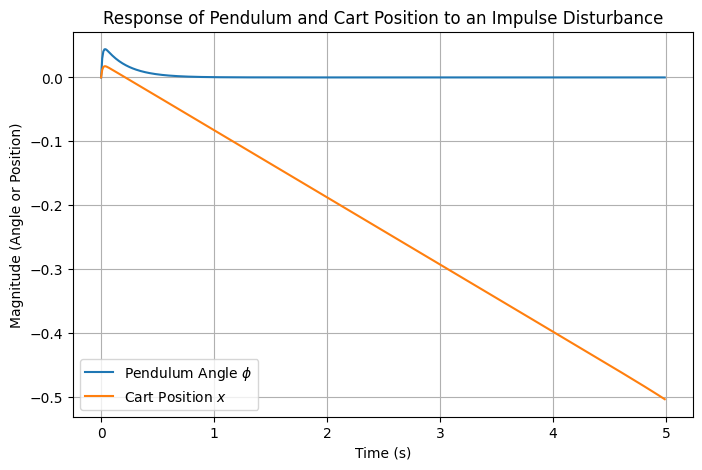

In [121]:
PID_Control(P_pend,P_cart,100,1,20)

As you can see, the cart moves in the negative direction with approximately constant velocity. Therefore, although the PID controller stabilizes the angle of the pendulum, this design would not be feasible to implement on an actual physical system. 

#### RootLocus

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


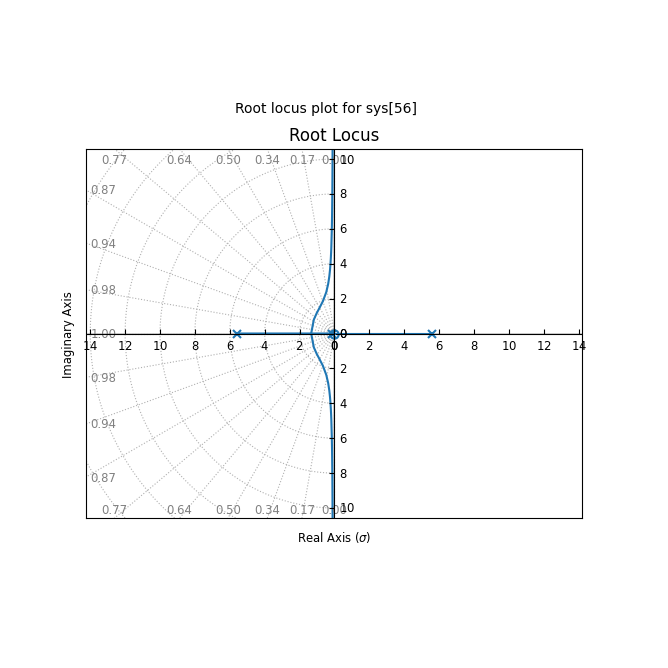

In [146]:
ct.root_locus(P_pend)

plt.title('Root Locus')
plt.xlabel('Real Axis ($\\sigma$)')
plt.ylabel('Imaginary Axis')
plt.grid(True)
plt.show()

### State Space

In [154]:
# Denominator for the A and B matrices
p = I * (M + m) + M * m * l**2

# --- State-Space Matrices ---
A = np.array([
    [0, 1, 0, 0],
    [0, -(I + m * l**2) * b / p, (m**2 * g * l**2) / p, 0],
    [0, 0, 0, 1],
    [0, -(m * l * b) / p, m * g * l * (M + m) / p, 0]
])

B = np.array([
    [0],
    [(I + m * l**2) / p],
    [0],
    [m * l / p]
])

C = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

D = np.array([
    [0],
    [0]
])

# --- Create the State-Space Model ---
sys_ss = ct.ss(A, B, C, D)

# Assign the names during creation for a more direct translation
states = ['x', 'x_dot', 'phi', 'phi_dot']
inputs = ['u']
outputs = ['x', 'phi']
sys_ss = ct.ss(A, B, C, D, states=states, inputs=inputs, outputs=outputs)

# --- Print the system to verify ---
print(sys_ss)

<StateSpace>: sys[322]
Inputs (1): ['u']
Outputs (2): ['x', 'phi']
States (4): ['x', 'x_dot', 'phi', 'phi_dot']

A = [[ 0.          1.          0.          0.        ]
     [ 0.         -0.18181818  2.67272727  0.        ]
     [ 0.          0.          0.          1.        ]
     [ 0.         -0.45454545 31.18181818  0.        ]]

B = [[0.        ]
     [1.81818182]
     [0.        ]
     [4.54545455]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0.]
     [0.]]


In [155]:
# Eigenvalues of the A matrix
eigenvalues = np.linalg.eigvals(sys_ss.A)
print("1. Eigenvalues of the A matrix (Poles of the system)")
print(eigenvalues)

# Controllability
# Calculate the Controllability Matrix (Wc)
Wc = ct.ctrb(sys_ss.A, sys_ss.B)

# The system is controllable if the rank of Wc equals the number of states (n)
n = sys_ss.A.shape[0] # Number of states
rank_Wc = np.linalg.matrix_rank(Wc)

print("2. Controllability Analysis")
print(f"Controllability Matrix (Wc):\n{Wc}")
print(f"Number of states (n): {n}")
print(f"Rank of Wc: {rank_Wc}")

# Observability
# Calculate the Observability Matrix (Wo)
Wo = ct.obsv(sys_ss.A, sys_ss.C)

# The system is observable if the rank of Wo equals the number of states (n)
rank_Wo = np.linalg.matrix_rank(Wo)

print("3. Observability Analysis")
print(f"Observability Matrix (Wo):\n{Wo}")
print(f"Number of states (n): {n}")
print(f"Rank of Wo: {rank_Wo}")


1. Eigenvalues of the A matrix (Poles of the system)
[ 0.         -0.14283164 -5.60409413  5.56510758]
2. Controllability Analysis
Controllability Matrix (Wc):
[[  0.           1.81818182  -0.33057851  12.20886551]
 [  1.81818182  -0.33057851  12.20886551  -4.42865924]
 [  0.           4.54545455  -0.82644628 141.88580015]
 [  4.54545455  -0.82644628 141.88580015 -31.319582  ]]
Number of states (n): 4
Rank of Wc: 4
3. Observability Analysis
Observability Matrix (Wo):
[[ 1.          0.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.         -0.18181818  2.67272727  0.        ]
 [ 0.         -0.45454545 31.18181818  0.        ]
 [ 0.          0.03305785 -0.48595041  2.67272727]
 [ 0.          0.08264463 -1.21487603 31.18181818]]
Number of states (n): 4
Rank of Wo: 4


### LQR

The simplest case is to assume $R=1$, and $Q = C'C$. The cost function corresponding to this $R$ and $Q$ places equal importance on the control and the state variables which are outputs (the pendulum's angle and the cart's position).


In [160]:
display(sys_ss)
Q = sys_ss.C.T @ sys_ss.C
display(Q)

StateSpace(
array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        , -0.18181818,  2.67272727,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        , -0.45454545, 31.18181818,  0.        ]]),
array([[0.        ],
       [1.81818182],
       [0.        ],
       [4.54545455]]),
array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]]),
array([[0.],
       [0.]]),
states=['x', 'x_dot', 'phi', 'phi_dot'], outputs=['x', 'phi'],
inputs=['u'])

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [172]:
def LQR_Control(Q,R):
    # Calculate the LQR gain matrix K
    K, X, E = ct.lqr(sys_ss.A, sys_ss.B, Q, R)
    print("## LQR Gain Matrix K:")
    print(K)
    
    # Define the Closed-Loop System Matrices (Ac, Bc, Cc, Dc)
    # Ac = A - B*K
    Ac = sys_ss.A - sys_ss.B @ K
    Bc = sys_ss.B
    Cc = sys_ss.C
    Dc = sys_ss.D
    
    # Create the Closed-Loop State-Space System
    sys_cl = ct.StateSpace(Ac, Bc, Cc, Dc,
                           states=states,
                           inputs=['r'], 
                           outputs=outputs)
    
    print("Closed-Loop System State-Space:")
    print(sys_cl)
    
    # Simulate the Step Response (LQR)
    t = np.arange(0, 10, 0.01)
    
    # Reference input: a step of 0.2
    r_magnitude = 0.2
    r = r_magnitude * np.ones_like(t)
    
    # Simulate the closed-loop system response
    t, y = ct.forced_response(sys_cl, T=t, U=r, X0=0)
    # Plot the Results
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot cart position (x) on the left Y-axis (ax1)
    ax1.plot(t, y[0, :], 'b-')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Cart Position (m)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)
    
    # Create a second Y-axis for the pendulum angle (phi)
    ax2 = ax1.twinx()
    ax2.plot(t, y[1, :], 'r-')
    ax2.set_ylabel('Pendulum Angle (radians)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title('Step Response with LQR Control ($r=0.2$ m step)')
    plt.tight_layout()
    plt.show()

## LQR Gain Matrix K:
[[-1.         -1.65671003 18.6853959   3.45943818]]
Closed-Loop System State-Space:
<StateSpace>: sys[340]
Inputs (1): ['r']
Outputs (2): ['x', 'phi']
States (4): ['x', 'x_dot', 'phi', 'phi_dot']

A = [[  0.           1.           0.           0.        ]
     [  1.81818182   2.83038186 -31.30071982  -6.28988759]
     [  0.           0.           0.           1.        ]
     [  4.54545455   7.07595466 -53.75179955 -15.72471898]]

B = [[0.        ]
     [1.81818182]
     [0.        ]
     [4.54545455]]

C = [[1. 0. 0. 0.]
     [0. 0. 1. 0.]]

D = [[0.]
     [0.]]


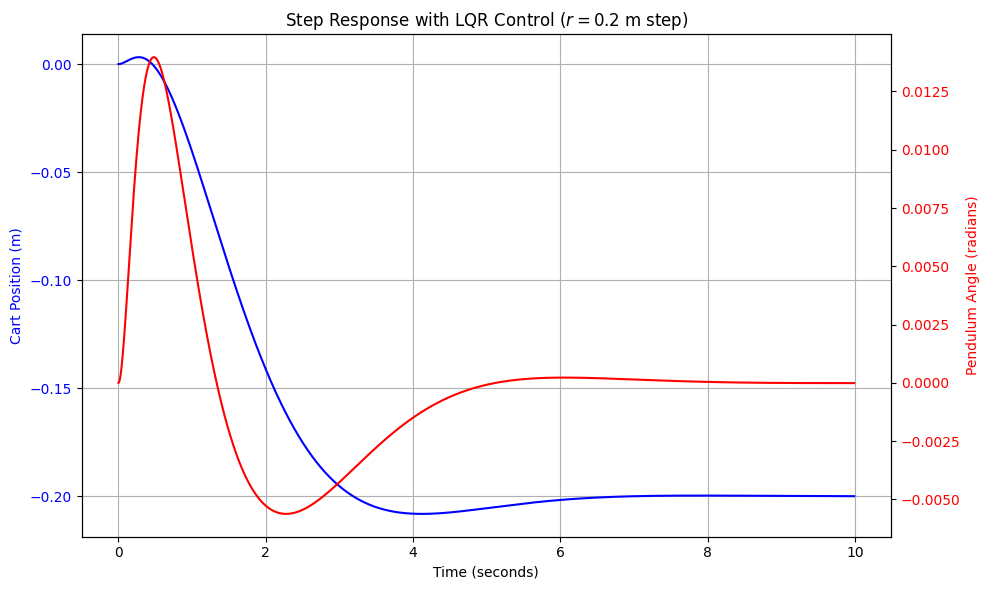

In [183]:
Q = sys_ss.C.T @ sys_ss.C
R = 1
LQR_Control(Q,R)

Q [[           1            0            0            0]
 [           0            5            0            0]
 [           0            0            1            0]
 [           0            0            0            1]]
R 0.1
## LQR Gain Matrix K:
[[          -3           -9           47           10]]
Closed-Loop System State-Space:
<StateSpace>: sys[344]
Inputs (1): ['r']
Outputs (2): ['x', 'phi']
States (4): ['x', 'x_dot', 'phi', 'phi_dot']

A = [[           0            1            0            0]
     [           6           16          -82          -18]
     [           0            0            0            1]
     [          14           40         -181          -44]]

B = [[           0]
     [           2]
     [           0]
     [           5]]

C = [[           1            0            0            0]
     [           0            0            1            0]]

D = [[           0]
     [           0]]


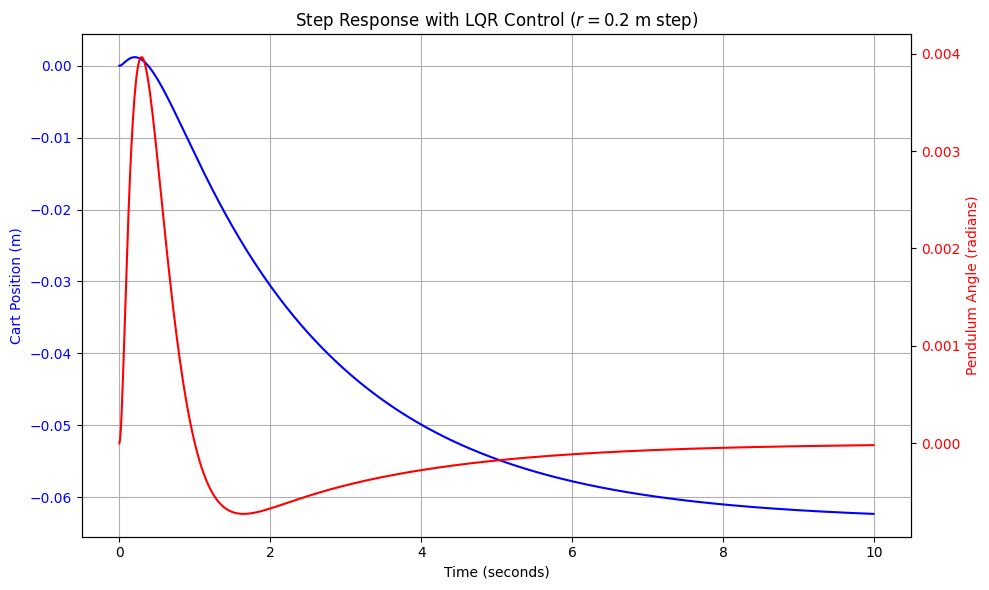

In [187]:
Q = sys_ss.C.T @ sys_ss.C
Q[1,1] = 5
Q[3,3] = 1
R = 0.1
np.set_printoptions(suppress=True, precision=0, formatter={'float_kind': lambda x: "%12.0f" % x})
print("Q",Q)
print("R",R)
LQR_Control(Q,R)

## Reference

1. University of Michigan (n.d.). Control Tutorials for MATLAB and Simulink - Inverted Pendulum: System Modeling. [online] ctms.engin.umich.edu. Available at: https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling.